# CSCB FINAL PROJECT Q3

In [408]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import celloracle as co
import warnings
warnings.filterwarnings(action='once')

co.check_python_requirements()
co.test_R_libraries_installation()

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300
save_folder = "figures"
os.makedirs(save_folder, exist_ok=True)

1 package does not meet CellOracle requirement.
 Your numba version is 0.48.0. Please install numba>=0.50.1


In [409]:
training = sc.read_h5ad("Kannan_perinatal_reference.h5ad") 
prdmko = sc.read_h5ad('wu_prdm16.h5ad') # validation, normalized

In [410]:
## default network
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()
base_GRN.head()

,peak_id,gene_short_name,9430076c15rik,Ac002126.6,Ac012531.1,Ac226150.2,Afp,Ahr,Ahrr,Aire,...,Znf784,Znf8,Znf816,Znf85,Zscan10,Zscan16,Zscan22,Zscan26,Zscan31,Zscan4
0,chr10_100050979_100052296,4930430F08Rik,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,chr10_101006922_101007748,SNORA17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,chr10_101144061_101145000,Mgat4c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,chr10_10148873_10149183,9130014G24Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,chr10_10149425_10149815,9130014G24Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [690]:
#this is our raw direct conversion data with columns in the obs dataframe that correspond to outputs from q1 and q2
adata = sc.read_h5ad("raw_data_postq1q2.h5ad")

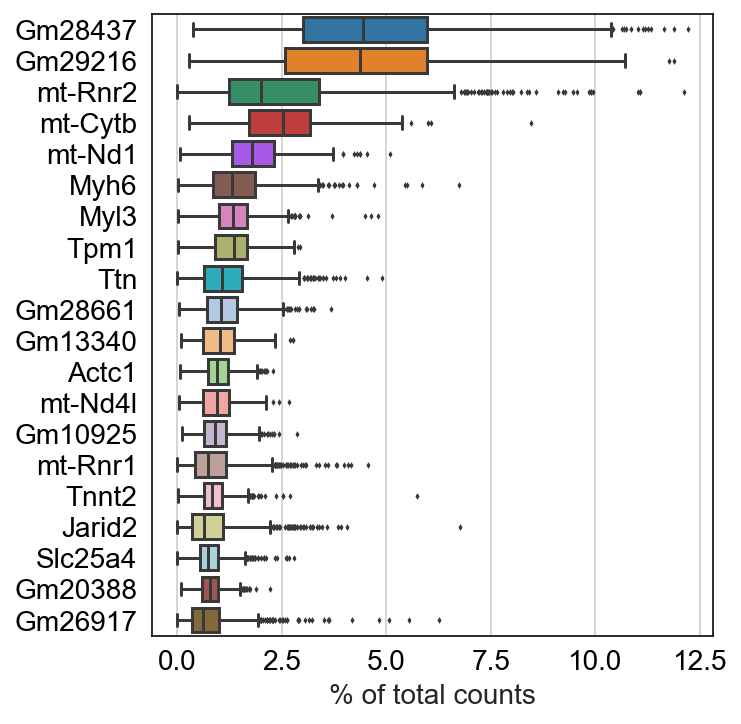

In [412]:
sc.pl.highest_expr_genes(training, n_top=20, )
training.raw=training


In [413]:
training.var['mt']= training.var_names.str.startswith(("mt-"))
training.var['ribo'] = training.var_names.str.startswith(("Rps","Rpl"))
sc.pp.calculate_qc_metrics(training, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)



In [415]:
## A function designed to do the preprocessing and cleaning of the data. adapted from part 6 in HW2. 
# This function takes in four arguments. 
# It takes in an Anndata object and three boolean arguments dictating whether to remove cells with high ribosomal expressions, high mitochondrial expressions, or genes with low expressions. 

def autoAnalysis(adata, exclude_high_ribo = True, exclude_high_mito = True, exclude_undetected_gene = True):
    print("Number of genes: ",adata.n_vars)
    print("Number of cells: ",adata.n_obs)
    ## Identify mitochondrial, ribosomal genes
    adata.var['mt']= adata.var_names.str.startswith(("mt-"))
    print("number of mitochondrial genes: ", sum(adata.var['mt']))
    adata.var['ribo'] = adata.var_names.str.startswith(("Rps","Rpl"))
    print("number of ribosomal genes: ", sum(adata.var['ribo']))
    sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)
    ## Filtering out low-quality mt and ribo genes
    if exclude_high_mito == True: 
        # filter for percent mt > 25% 
        adata = adata[adata.obs['pct_counts_mt'] < 25, :]
        print("Number of cells after mt removal: ",adata.n_obs)
    if exclude_high_ribo == True: 
        # filter for percent ribo > 50%
        adata = adata[adata.obs['pct_counts_ribo'] < 20, :]
        print("Number of cells after ribo removal: ",adata.n_obs)
    axs = sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],jitter=0.4, multi_panel=True)
    sc.pl.highest_expr_genes(adata, n_top=10, palette="Blues", width=.3)
    ## Filtering out undetected genes (below gThresh)
    if exclude_undetected_gene == True: 
        ## excluding undetected genes (gene expression below gThresh)
        gThresh = 350
        sc.pp.filter_genes(adata, min_cells=gThresh)
        print("Number of genes after removing undetected ones: ",adata.n_vars)
    ## filtering out genes that are highly expressed but not informative 
    mito_genes = adata.var['mt']
    ribo_genes = adata.var['ribo']
    malat_genes = adata.var_names.str.startswith("Malat1")
    #genes_to_remove = np.add(mito_genes, ribo_genes) I am removing this line for now, as we want to keep mitochondrial genes
    genes_to_remove = np.add(ribo_genes, malat_genes)
    genes_to_keep = np.invert(genes_to_remove)
    adata = adata[:,genes_to_keep]
    print("Number of genes after cleaning: ",adata.n_vars)
    adM1Norm = adata.copy()
    adM1Norm.raw=adM1Norm
    sc.pp.filter_genes(adM1Norm, min_cells=5)
    sc.pp.normalize_per_cell(adM1Norm, counts_per_cell_after=1e4)
    sc.pp.log1p(adM1Norm)
    sc.pp.highly_variable_genes(adM1Norm, min_mean=0.0125, max_mean=5, min_disp=0.25)


    return adM1Norm
    
    
    

Number of genes:  29593
Number of cells:  936
number of mitochondrial genes:  28
number of ribosomal genes:  341
Number of cells after mt removal:  933
Number of cells after ribo removal:  933


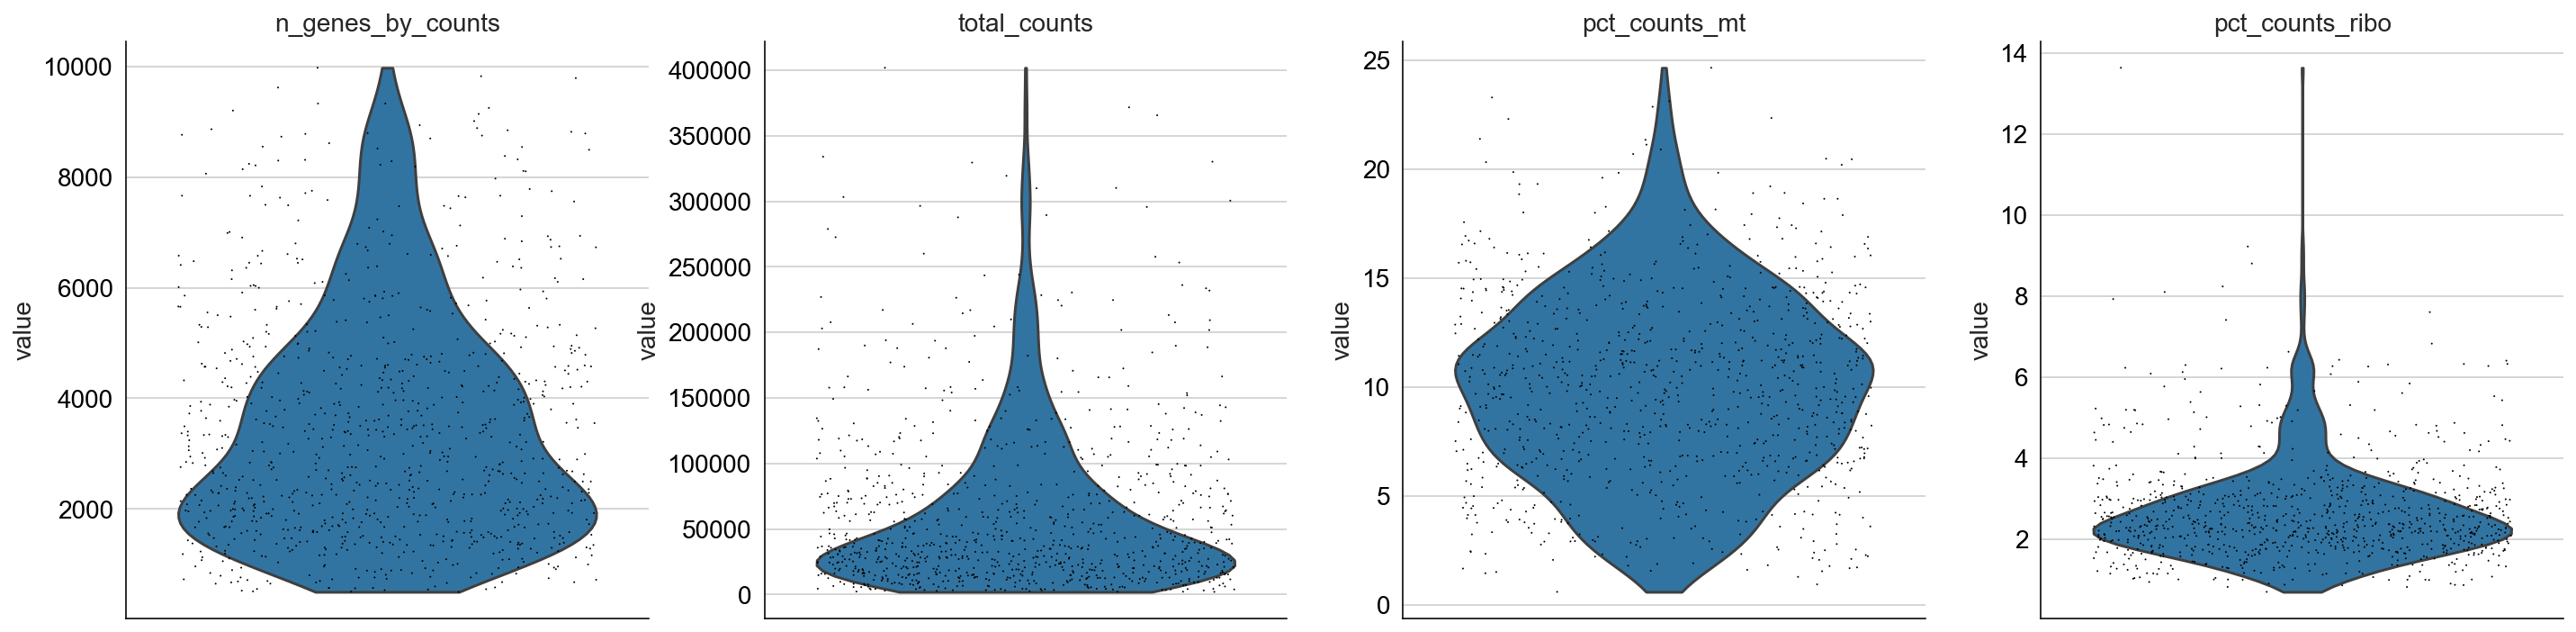

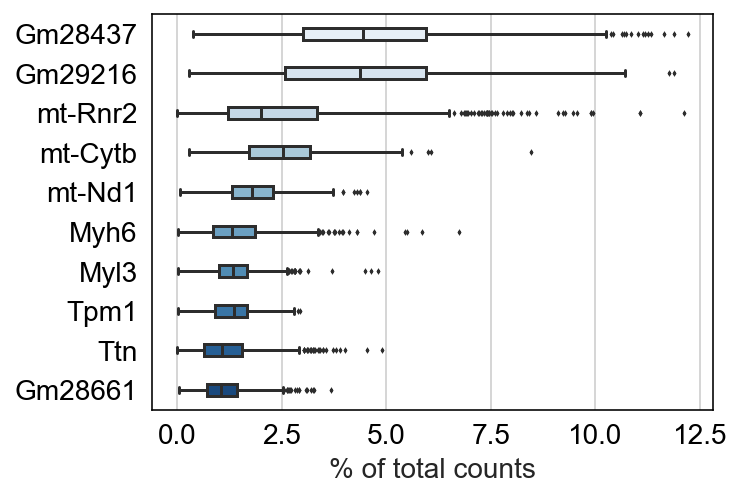

Number of genes after removing undetected ones:  2902
Number of genes after cleaning:  2763


In [416]:
trainNorm = autoAnalysis(training)

In [417]:
## hvg
sc.pp.highly_variable_genes(trainNorm, min_mean=0.0125, max_mean=5, min_disp=0.25)

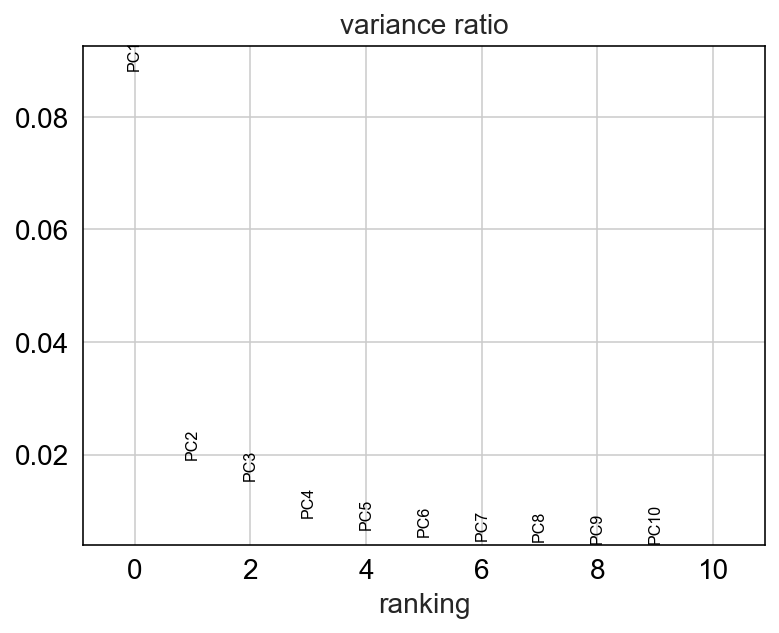

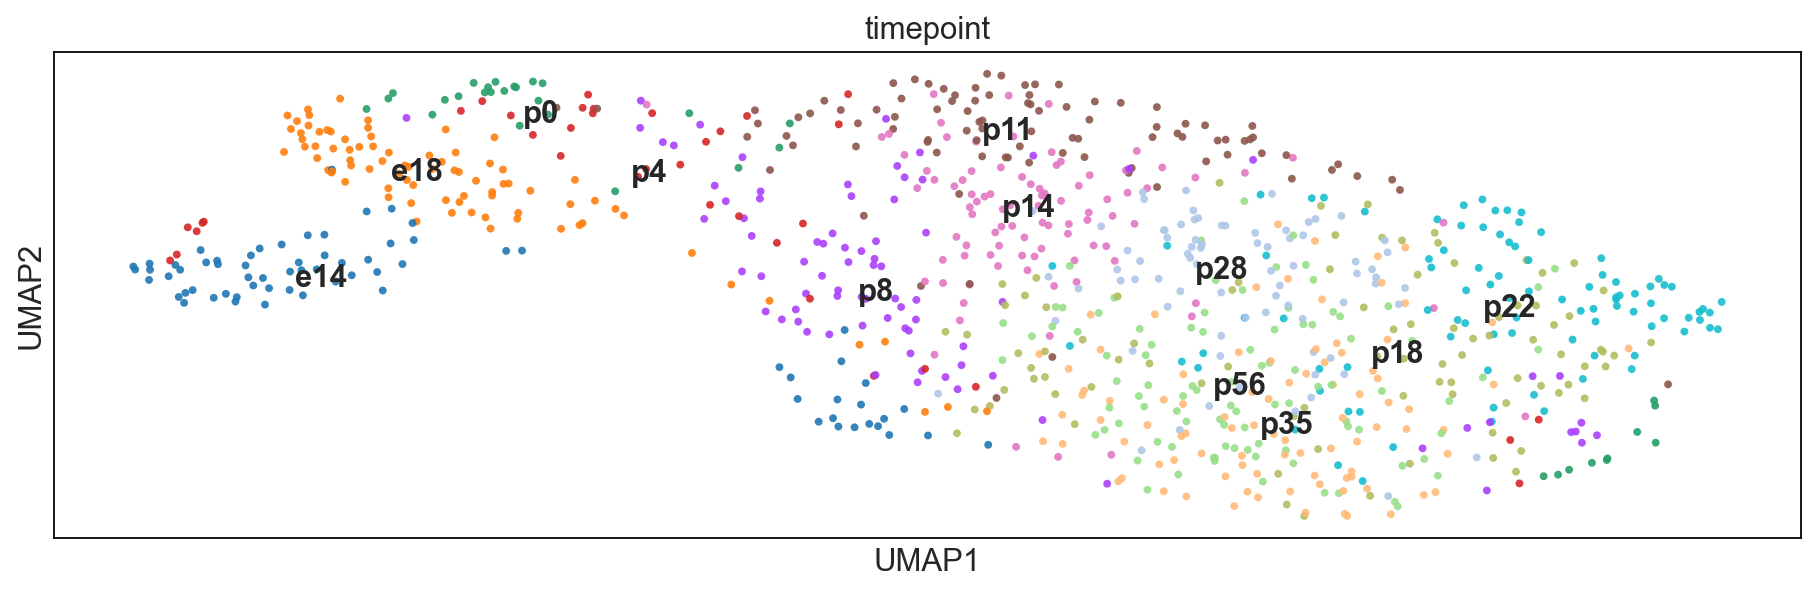

In [418]:
## The following cells perform PCA analysis and leiden clustering on the young dataset 
## to reduce the dimension of the data for easy analysis and better classification. 

sc.pp.scale(trainNorm, max_value=10)
sc.tl.pca(trainNorm, n_comps=10, use_highly_variable=True)

sc.pl.pca_variance_ratio(trainNorm, 10, )

# finding PCAs and visualizing them
sc.set_figure_params(figsize="14, 4")

npcs = 10
sc.pp.neighbors(trainNorm, n_neighbors=35, n_pcs=npcs)
sc.tl.leiden(trainNorm,.25)
sc.tl.umap(trainNorm, .5)
sc.pl.umap(trainNorm, color=["timepoint"], alpha=.9, s=15, legend_loc='on data', size=50,)

In [419]:
## loading celloracle

oracle = co.Oracle()
trainNorm.X=trainNorm.raw.X
oracle.import_anndata_as_raw_count(adata=trainNorm,
                                    cluster_column_name="timepoint", #good
                                   embedding_name="X_pca")
oracle.import_TF_data(TF_info_matrix=base_GRN)


In [420]:
## more oracle stuff

oracle.perform_PCA()
n_comps = 50
n_cell = oracle.adata.shape[0]
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)



Auto-selected k is :23


In [421]:
## build links 
warnings.filterwarnings('ignore') #Otherwise, np.int nightmare
links = oracle.get_links(cluster_name_for_GRN_unit="timepoint", alpha=10,
                         verbose_level=10, test_mode=False, n_jobs=-1)

  0%|          | 0/12 [00:00<?, ?it/s]

inferring GRN for e14...


  0%|          | 0/2169 [00:00<?, ?it/s]

inferring GRN for e18...


  0%|          | 0/2169 [00:00<?, ?it/s]

inferring GRN for p0...


  0%|          | 0/2169 [00:00<?, ?it/s]

inferring GRN for p11...


  0%|          | 0/2169 [00:00<?, ?it/s]

inferring GRN for p14...


  0%|          | 0/2169 [00:00<?, ?it/s]

inferring GRN for p18...


  0%|          | 0/2169 [00:00<?, ?it/s]

inferring GRN for p22...


  0%|          | 0/2169 [00:00<?, ?it/s]

inferring GRN for p28...


  0%|          | 0/2169 [00:00<?, ?it/s]

inferring GRN for p35...


  0%|          | 0/2169 [00:00<?, ?it/s]

inferring GRN for p4...


  0%|          | 0/2169 [00:00<?, ?it/s]

inferring GRN for p56...


  0%|          | 0/2169 [00:00<?, ?it/s]

inferring GRN for p8...


  0%|          | 0/2169 [00:00<?, ?it/s]

In [422]:
## prune links
links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, use_cluster_specific_TFdict=True)

fitting GRN again...
calculating GRN in e14


  0%|          | 0/2763 [00:00<?, ?it/s]

genes_in_gem: 2763
models made for 675 genes
calculating GRN in e18


  0%|          | 0/2763 [00:00<?, ?it/s]

genes_in_gem: 2763
models made for 801 genes
calculating GRN in p0


  0%|          | 0/2763 [00:00<?, ?it/s]

genes_in_gem: 2763
models made for 634 genes
calculating GRN in p11


  0%|          | 0/2763 [00:00<?, ?it/s]

genes_in_gem: 2763
models made for 878 genes
calculating GRN in p14


  0%|          | 0/2763 [00:00<?, ?it/s]

genes_in_gem: 2763
models made for 779 genes
calculating GRN in p18


  0%|          | 0/2763 [00:00<?, ?it/s]

genes_in_gem: 2763
models made for 588 genes
calculating GRN in p22


  0%|          | 0/2763 [00:00<?, ?it/s]

genes_in_gem: 2763
models made for 738 genes
calculating GRN in p28


  0%|          | 0/2763 [00:00<?, ?it/s]

genes_in_gem: 2763
models made for 813 genes
calculating GRN in p35


  0%|          | 0/2763 [00:00<?, ?it/s]

genes_in_gem: 2763
models made for 482 genes
calculating GRN in p4


  0%|          | 0/2763 [00:00<?, ?it/s]

genes_in_gem: 2763
models made for 702 genes
calculating GRN in p56


  0%|          | 0/2763 [00:00<?, ?it/s]

genes_in_gem: 2763
models made for 580 genes
calculating GRN in p8


  0%|          | 0/2763 [00:00<?, ?it/s]

genes_in_gem: 2763
models made for 574 genes


In [423]:
oracle.simulate_shift(perturb_condition={"Prdm16": 0.0}, n_propagation=3)
# Fold change is stored here.
oracle.adata.layers['delta_X']

array([[ 0.        ,  0.        , -0.49794637, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , -0.26322097, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , -0.51253549, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [424]:
# in this step I am using the fold change predictions to calculate the new gene expression values for each cell and each gene
# i store this in a data frame called predicted_prdmko, and will then store this in an anndata called predicted_prdmko
predicted_prdmko=pd.DataFrame(oracle.adata.layers['normalized_count']*np.exp(oracle.adata.layers['delta_X']))
predicted_prdmko.columns=trainNorm.to_df().columns
predicted_prdmko.index=trainNorm.to_df().index

In [425]:
predicted_prdmko=sc.AnnData(X=predicted_prdmko,obs=trainNorm.obs,var=trainNorm.var)

In [426]:
trainNorm.obs['class']='WT'
predicted_prdmko.obs['class']='KO'

In [427]:
## to validate that our predicted prdm16 ko transcriptome is actually similar to real life, I will train a model on the 
## real prdm16ko vs real prdm16wt at E13.5, and then test this on our simulated and real E14 sample. just to make sure it is working! 

prdmko.obs['Prdm16']=prdmko.obs['sample'].map({'WT1':'WT','WT2':'WT','Prdm16cKO1':'KO','Prdm16cKO2':'KO'})

In [428]:
prdmko

AnnData object with n_obs × n_vars = 5000 × 32285
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'Prdm16'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [429]:
import pySingleCellNet as pySCN

In [430]:
# finding genes that are common to all matrices for pyscn

intersect=[]
for i in prdmko.var.index:
    if i in list(predicted_prdmko.var.index):
        intersect+=[i]

In [431]:
prdmko_clf=prdmko[:,intersect]
predicted_prdmko_clf=predicted_prdmko[:,intersect]
trainNorm_clf=trainNorm[:,intersect]

In [432]:
predicted_prdmko_clf = predicted_prdmko_clf[predicted_prdmko_clf.obs["n_genes_by_counts"]>=500,:].copy()



In [433]:
expTrain, expVal = pySCN.splitCommonAnnData(prdmko_clf, ncells=200,dLevel='Prdm16')



KO : 
2613
WT : 
2387


In [434]:
predicted_prdmko_clf_e14=predicted_prdmko_clf[predicted_prdmko_clf.obs.timepoint=='e14']

In [435]:
[cgenesA, xpairs, tspRF] = pySCN.scn_train(expTrain, nTopGenes = 100, nRand = 0,
                                           nTrees = 1000 ,nTopGenePairs = 100, dLevel = 'Prdm16', 
                                           stratify=True, limitToHVG=True)

HVG
Matrix normalized
There are  200  classification genes

KO
WT
There are 198 top gene pairs

Finished pair transforming the data



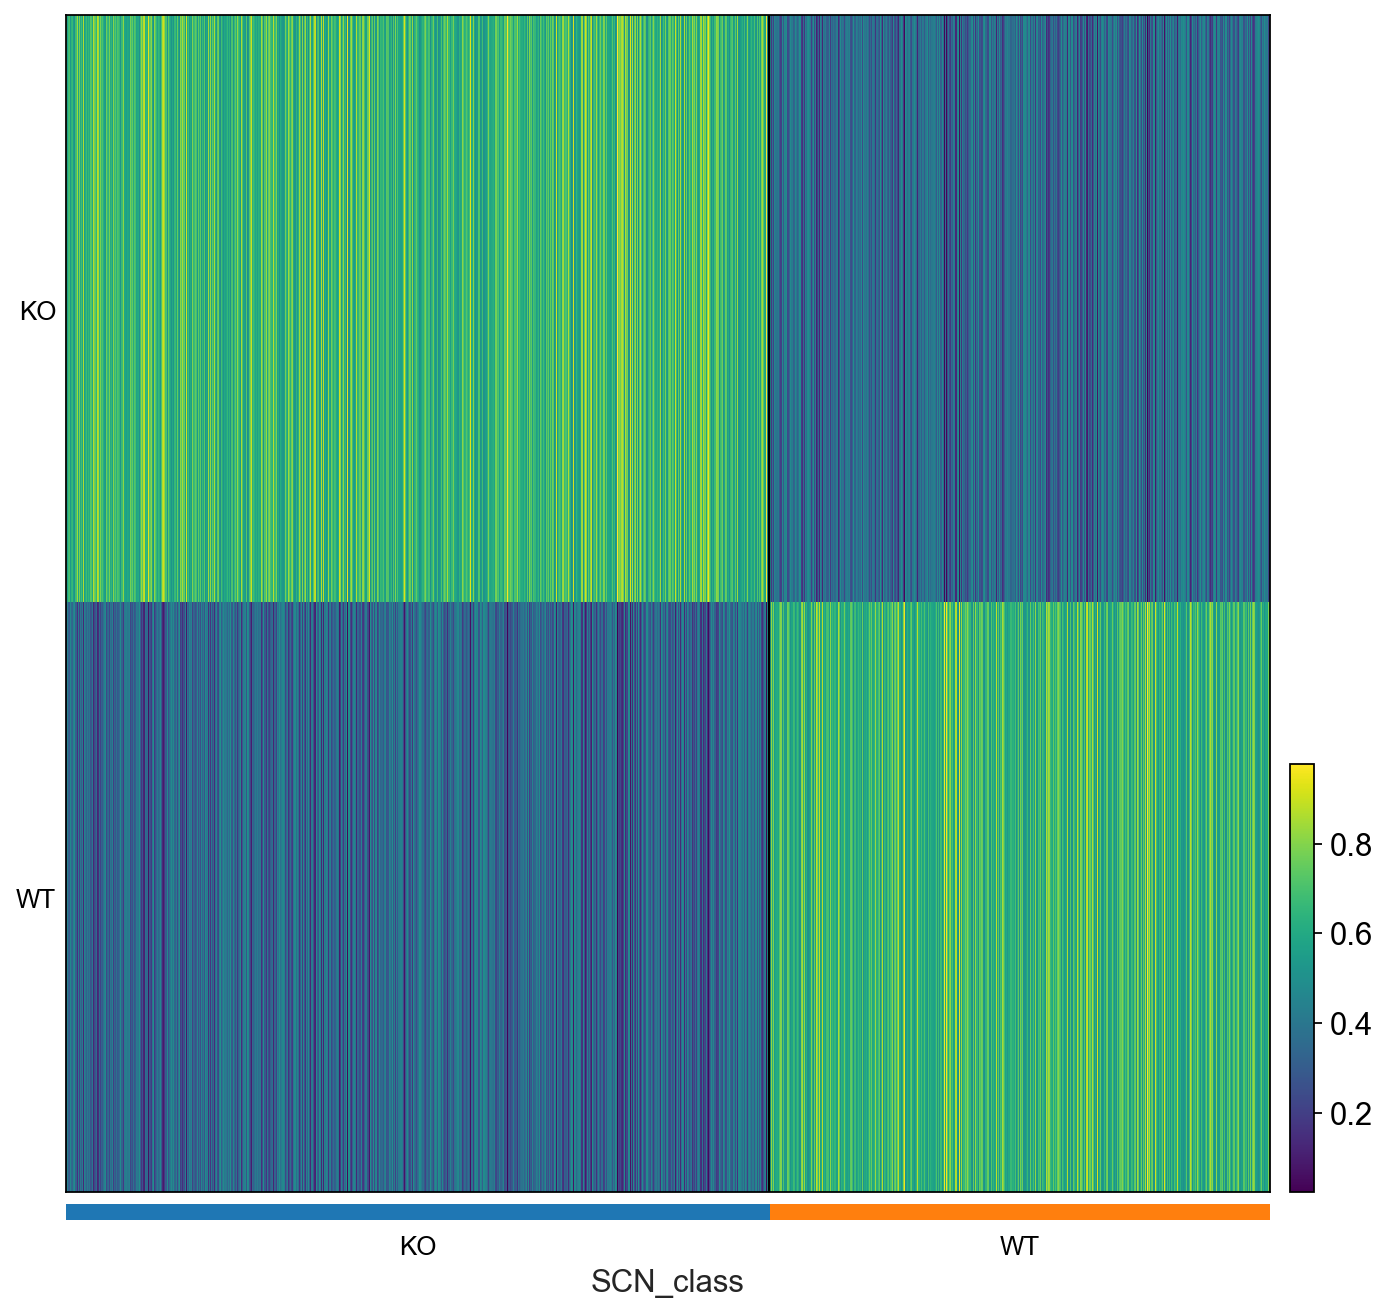

In [436]:
#sc.set_figure_params(fontsize=15)
adVal = pySCN.scn_classify(expVal, cgenesA, xpairs, tspRF, nrand = 0)
ax = sc.pl.heatmap(adVal, adVal.var_names.values, groupby='SCN_class', cmap='viridis', dendrogram=False, swap_axes=True,figsize=(10,10))



In [437]:
#use classifier on predicted ko
predicted_prdmko_clf_e14_classified = pySCN.scn_classify(predicted_prdmko_clf_e14, cgenesA, xpairs, tspRF, nrand = 0)
predicted_prdmko_clf_e14.obs['scn_prdm16']=predicted_prdmko_clf_e14_classified.obs.SCN_class

#use classifier on prior to simulation (trainNorm: all WT)
predicted_train_e14_classified = pySCN.scn_classify(trainNorm_clf, cgenesA, xpairs, tspRF, nrand = 0)
trainNorm_clf.obs['scn_prdm16']=predicted_train_e14_classified.obs.SCN_class







In [438]:
trainNorm_clf.obs['class']='WT'
predicted_prdmko_clf_e14.obs['class']='KO'

In [439]:
val_wt_true=sum(trainNorm_clf.obs['class']==trainNorm_clf.obs['scn_prdm16'])
val_wt_false=sum(trainNorm_clf.obs['class']!=trainNorm_clf.obs['scn_prdm16'])
val_predko_true=sum(predicted_prdmko_clf_e14.obs['class']==predicted_prdmko_clf_e14.obs['scn_prdm16'])
val_predko_false=sum(predicted_prdmko_clf_e14.obs['class']!=predicted_prdmko_clf_e14.obs['scn_prdm16'])




In [440]:
validation_results=pd.DataFrame()
validation_results['Kannan E14 WT']=[val_wt_true,val_wt_false]
validation_results['Kannan E14 KO - Cell Oracle Simulation']=[val_predko_false,val_predko_true]

In [441]:
validation_results.index=['WT','KO']

In [442]:
validation_results=validation_results/validation_results.sum(axis=0)

In [443]:
validation_results

,Kannan E14 WT,Kannan E14 KO - Cell Oracle Simulation
WT,0.906752,0.388889
KO,0.093248,0.611111


Text(0.5, 1.0, 'pySCN Prdm16 calls on Kannan E14 data')

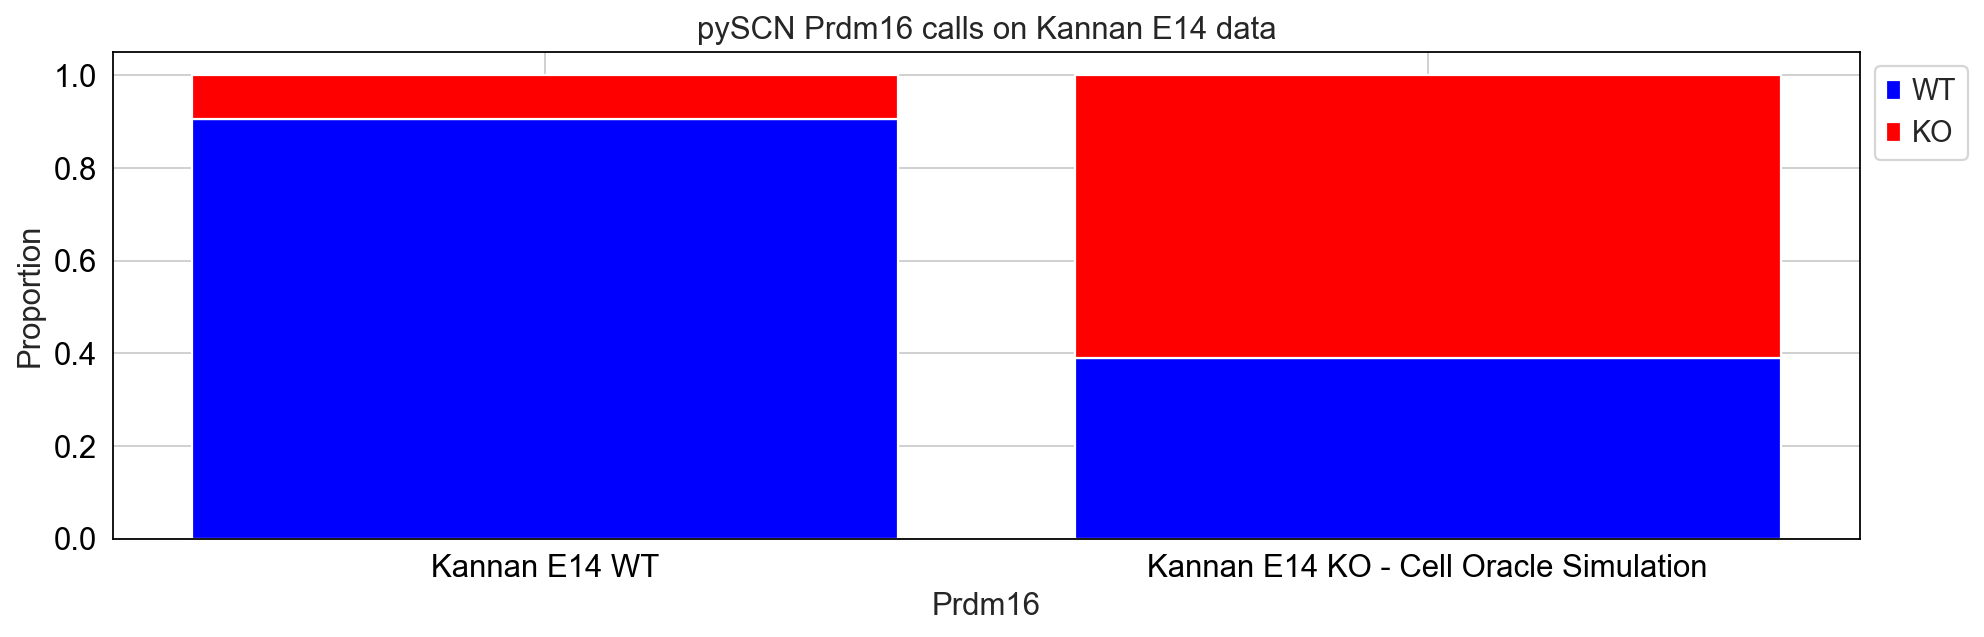

In [444]:
plt.bar(validation_results.columns,validation_results.loc['WT'],color='blue')
plt.bar(validation_results.columns,validation_results.loc['KO'],color='red',bottom=validation_results.loc['WT'])
plt.legend(["WT", "KO"],loc='upper right',bbox_to_anchor=(1.07, 1.0))
plt.xlabel('Prdm16')
plt.ylabel('Proportion')
plt.title('pySCN Prdm16 calls on Kannan E14 data')









## Train CellOracle on Direct Conversion Data

In [691]:
adata.obs['Timepoint (days)']=adata.obs['batch'].map({'1':'-1','2':'1','3':'2','4':'3','5':'7','6':'14'})



In [692]:
adata_cmc=adata[list(adata.obs['scn_celltype']=='cardiac muscle cell'),:]

In [693]:
## need to find genes that are common to both kannan cell oracle experiment

adata_cmc=adata_cmc[:,np.intersect1d(list(trainNorm.var.index),list(adata.var.index))]
adata_cmc.raw=adata_cmc


In [643]:
## A function designed to do the preprocessing and cleaning of the data. adapted from part 6 in HW2. 
# This function takes in four arguments. 
# It takes in an Anndata object and three boolean arguments dictating whether to remove cells with high ribosomal expressions, high mitochondrial expressions, or genes with low expressions. 

def autoAnalysis(adata, exclude_high_ribo = True, exclude_high_mito = True, exclude_undetected_gene = True):
    print("Number of genes: ",adata.n_vars)
    print("Number of cells: ",adata.n_obs)
    ## Identify mitochondrial, ribosomal genes
    adata.var['mt']= adata.var_names.str.startswith(("mt-"))
    print("number of mitochondrial genes: ", sum(adata.var['mt']))
    adata.var['ribo'] = adata.var_names.str.startswith(("Rps","Rpl"))
    print("number of ribosomal genes: ", sum(adata.var['ribo']))
    sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)
    ## Filtering out low-quality mt and ribo genes
    if exclude_high_mito == True: 
        # filter for percent mt > 25% 
        adata = adata[adata.obs['pct_counts_mt'] < 5, :]
        print("Number of cells after mt removal: ",adata.n_obs)
    if exclude_high_ribo == True: 
        # filter for percent ribo > 50%
        adata = adata[adata.obs['pct_counts_ribo'] < 50, :]
        print("Number of cells after ribo removal: ",adata.n_obs)
    axs = sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],jitter=0.4, multi_panel=True)
    sc.pl.highest_expr_genes(adata, n_top=10, palette="Blues", width=.3)
    ## Filtering out undetected genes (below gThresh)
    if exclude_undetected_gene == True: 
        ## excluding undetected genes (gene expression below gThresh)
        gThresh = 50
        sc.pp.filter_genes(adata, min_cells=gThresh)
        print("Number of genes after removing undetected ones: ",adata.n_vars)
    ## filtering out genes that are highly expressed but not informative 
    mito_genes = adata.var['mt']
    ribo_genes = adata.var['ribo']
    malat_genes = adata.var_names.str.startswith("Malat1")
    #genes_to_remove = np.add(mito_genes, ribo_genes) I am removing this line for now, as we want to keep mitochondrial genes
    genes_to_remove = np.add(ribo_genes, malat_genes)
    genes_to_keep = np.invert(genes_to_remove)
    adata = adata[:,genes_to_keep]
    print("Number of genes after cleaning: ",adata.n_vars)
    adM1Norm = adata.copy()
    adM1Norm.raw=adM1Norm
    sc.pp.filter_genes(adM1Norm, min_cells=5)
    sc.pp.normalize_per_cell(adM1Norm, counts_per_cell_after=1e4)
    sc.pp.log1p(adM1Norm)
    sc.pp.highly_variable_genes(adM1Norm, min_mean=0.0125, max_mean=5, min_disp=0.25)


    return adM1Norm
    
    
    

Number of genes:  2542
Number of cells:  746
number of mitochondrial genes:  3
number of ribosomal genes:  0
Number of cells after mt removal:  746
Number of cells after ribo removal:  746


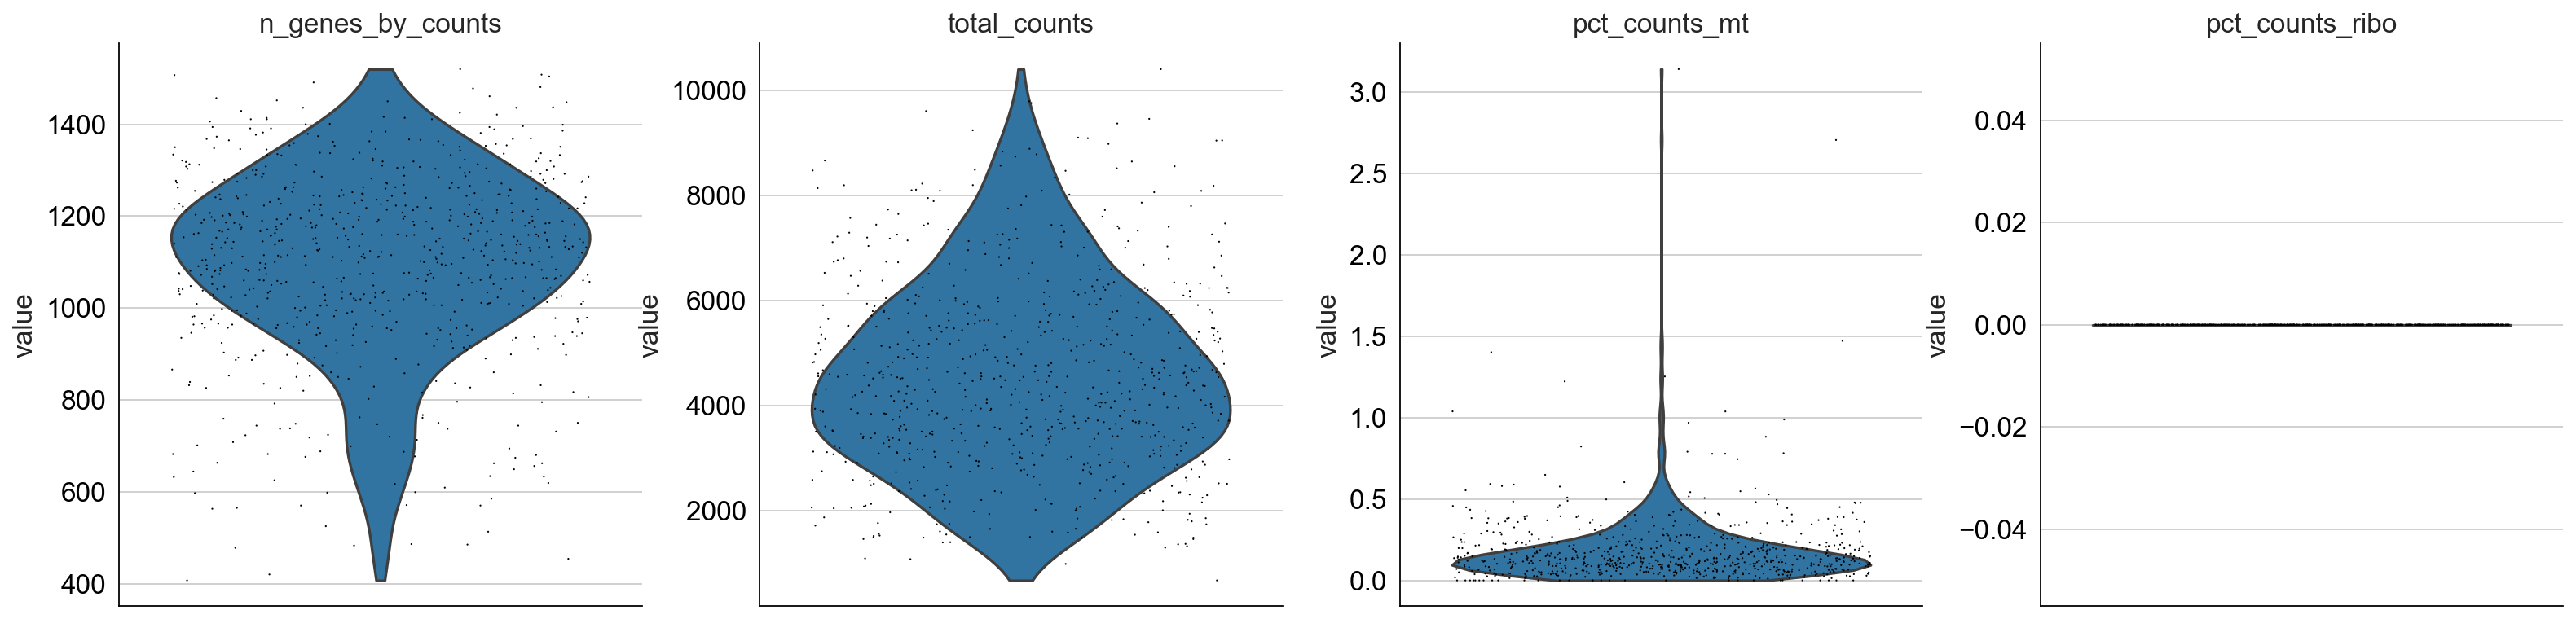

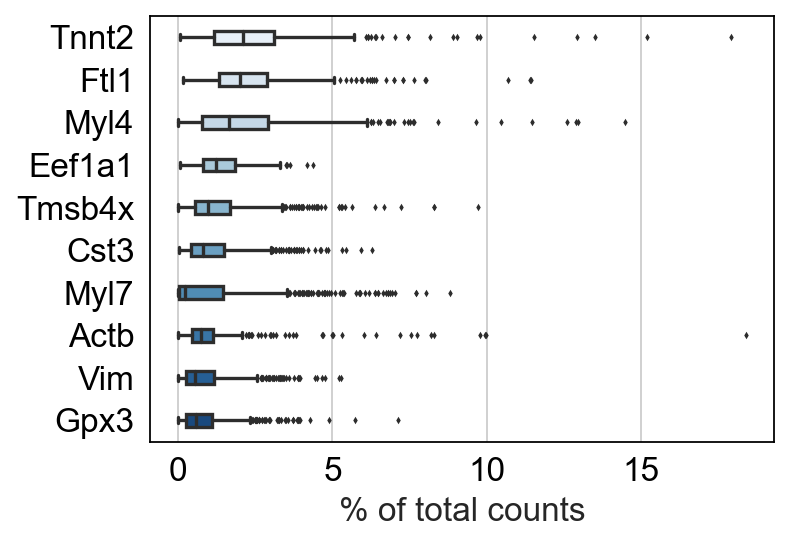

Number of genes after removing undetected ones:  2096
Number of genes after cleaning:  2096


In [644]:
direct_conv_celloracle=autoAnalysis(adata_cmc)


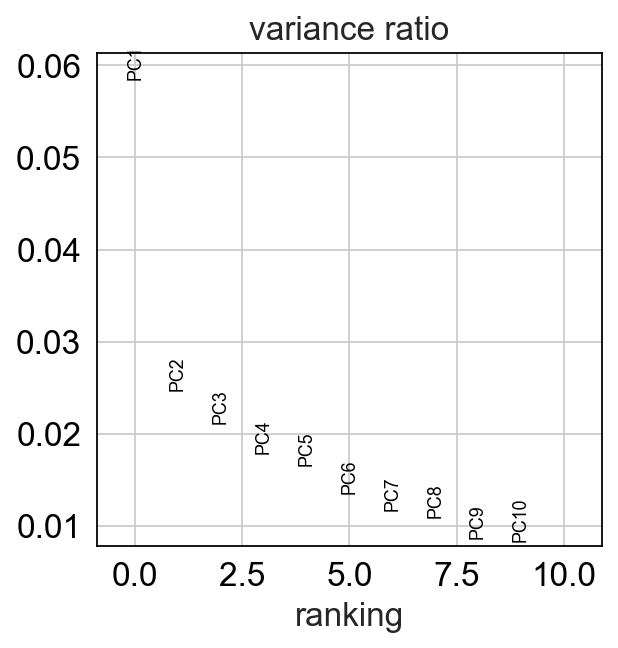

In [645]:
sc.pp.highly_variable_genes(direct_conv_celloracle, min_mean=0.0125, max_mean=5, min_disp=0.25)
sc.pp.scale(direct_conv_celloracle, max_value=10)
sc.tl.pca(direct_conv_celloracle, n_comps=10, use_highly_variable=True)
sc.pl.pca_variance_ratio(direct_conv_celloracle, 10, )
# finding PCAs and visualizing them
sc.set_figure_params(figsize="14, 4")
npcs = 10
sc.pp.neighbors(direct_conv_celloracle, n_neighbors=35, n_pcs=npcs)
sc.tl.leiden(direct_conv_celloracle,.25)
sc.tl.umap(direct_conv_celloracle, .5)

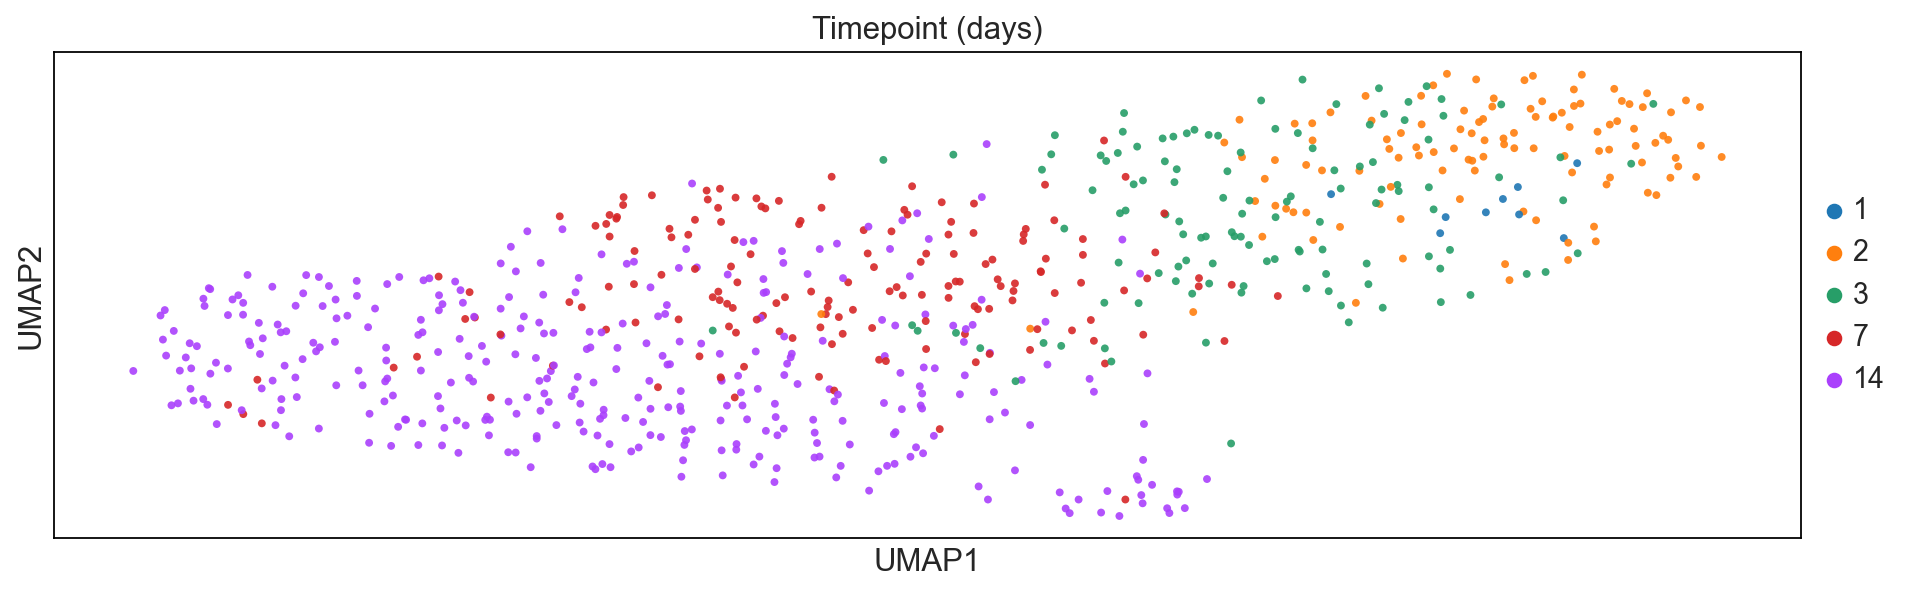

In [646]:
sc.pl.umap(direct_conv_celloracle, color=["Timepoint (days)"], alpha=.9, s=15, size=50,)


In [647]:
## default network
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()
base_GRN.head()

,peak_id,gene_short_name,9430076c15rik,Ac002126.6,Ac012531.1,Ac226150.2,Afp,Ahr,Ahrr,Aire,...,Znf784,Znf8,Znf816,Znf85,Zscan10,Zscan16,Zscan22,Zscan26,Zscan31,Zscan4
0,chr10_100050979_100052296,4930430F08Rik,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,chr10_101006922_101007748,SNORA17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,chr10_101144061_101145000,Mgat4c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,chr10_10148873_10149183,9130014G24Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,chr10_10149425_10149815,9130014G24Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [648]:
oracle = co.Oracle()
direct_conv_celloracle.X=direct_conv_celloracle.raw.X
oracle.import_anndata_as_raw_count(adata=direct_conv_celloracle,
                                    cluster_column_name="Timepoint (days)", #good
                                   embedding_name="X_pca")
oracle.import_TF_data(TF_info_matrix=base_GRN)

In [649]:
oracle.perform_PCA()
n_comps = 50
n_cell = oracle.adata.shape[0]
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

Auto-selected k is :18


In [650]:
warnings.filterwarnings('ignore') #Otherwise, np.int nightmare
links = oracle.get_links(cluster_name_for_GRN_unit="Timepoint (days)", alpha=10,
                         verbose_level=10, test_mode=False, n_jobs=-1)

  0%|          | 0/5 [00:00<?, ?it/s]

inferring GRN for 1...


  0%|          | 0/1823 [00:00<?, ?it/s]

inferring GRN for 14...


  0%|          | 0/1823 [00:00<?, ?it/s]

inferring GRN for 2...


  0%|          | 0/1823 [00:00<?, ?it/s]

inferring GRN for 3...


  0%|          | 0/1823 [00:00<?, ?it/s]

inferring GRN for 7...


  0%|          | 0/1823 [00:00<?, ?it/s]

In [651]:
links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, use_cluster_specific_TFdict=True)

fitting GRN again...
calculating GRN in 1


  0%|          | 0/2096 [00:00<?, ?it/s]

genes_in_gem: 2096
models made for 531 genes
calculating GRN in 14


  0%|          | 0/2096 [00:00<?, ?it/s]

genes_in_gem: 2096
models made for 799 genes
calculating GRN in 2


  0%|          | 0/2096 [00:00<?, ?it/s]

genes_in_gem: 2096
models made for 729 genes
calculating GRN in 3


  0%|          | 0/2096 [00:00<?, ?it/s]

genes_in_gem: 2096
models made for 686 genes
calculating GRN in 7


  0%|          | 0/2096 [00:00<?, ?it/s]

genes_in_gem: 2096
models made for 724 genes


In [652]:
marker_genes_dict = {'regulatory': oracle.active_regulatory_genes}

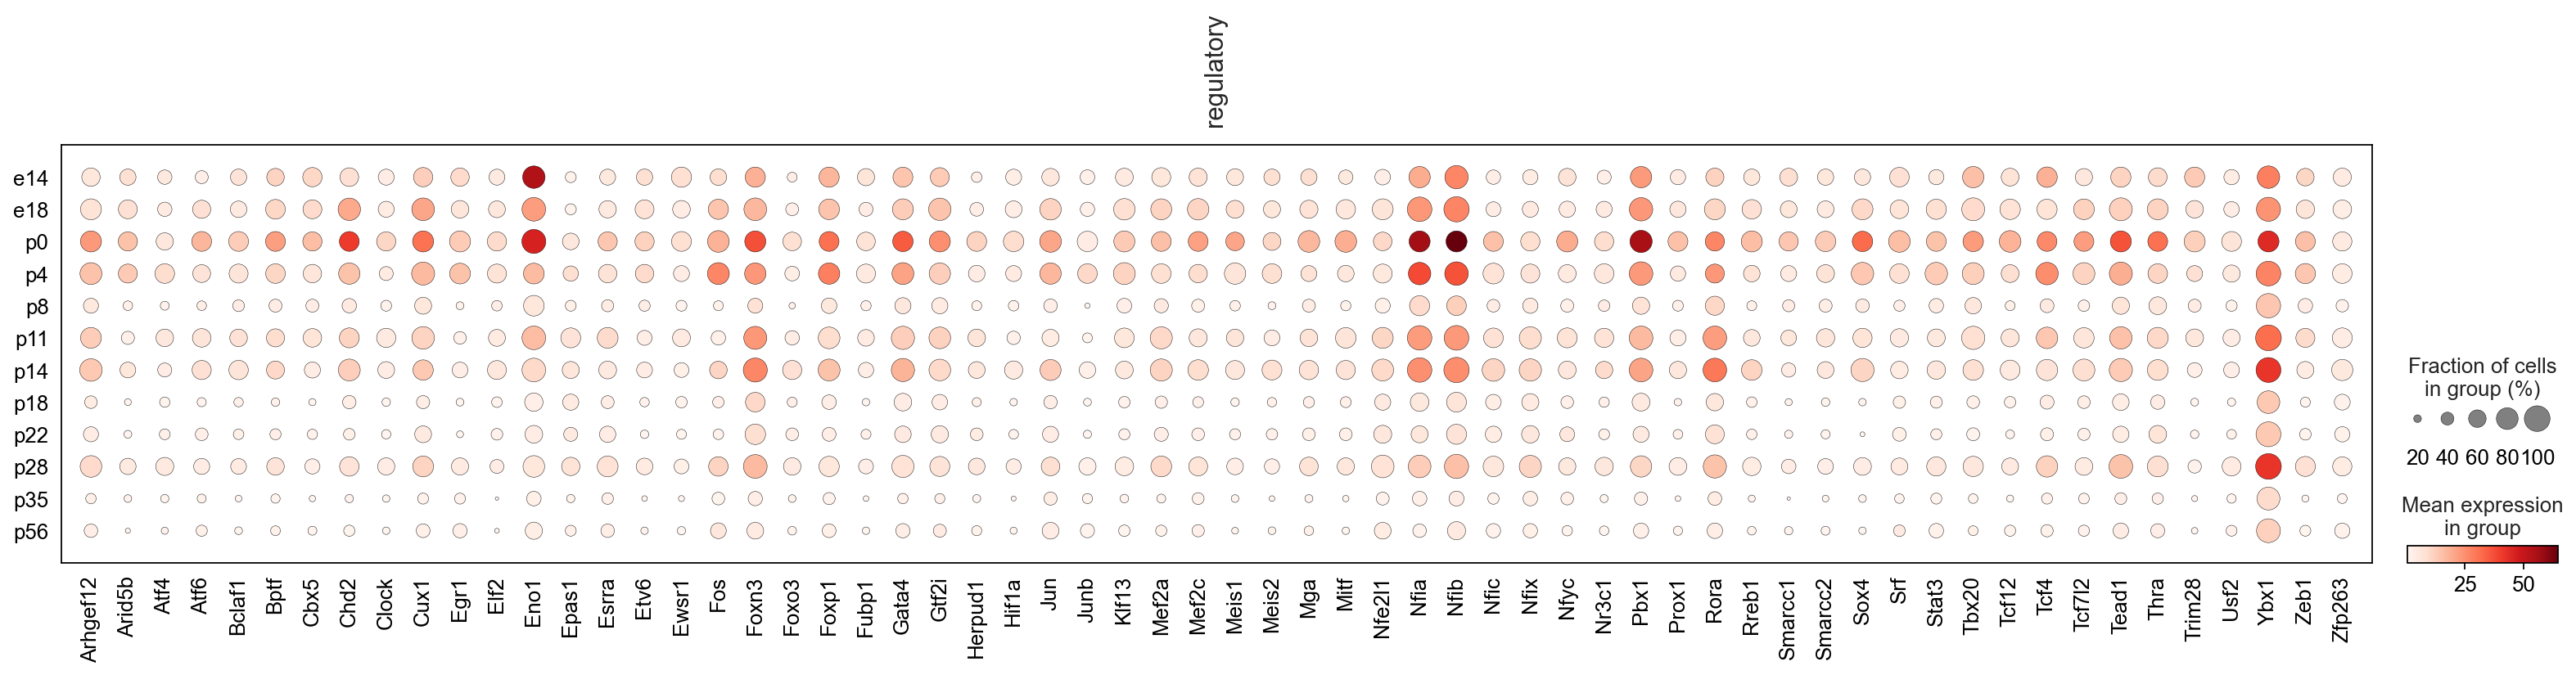

In [653]:
ax = sc.pl.dotplot(kannan_deg, marker_genes_dict, groupby='timepoint')


In [662]:
#first experiment
oracle.simulate_shift(perturb_condition={'Eno1':0,'Nfia':0,'Nfib':0,'Cux1':0}, n_propagation=3)
predicted_eno1nfianfibcux1ko=pd.DataFrame(oracle.adata.layers['normalized_count']*np.exp(oracle.adata.layers['delta_X']))
predicted_eno1nfianfibcux1ko=sc.AnnData(predicted_eno1nfianfibcux1ko,obs=direct_conv_celloracle.obs,var=direct_conv_celloracle.var)

In [656]:
#second experiment
oracle.simulate_shift(perturb_condition={'Eno1':3,'Nfia':2,'Nfib':2,'Cux1':1}, n_propagation=3)
predicted_eno1nfianfibcux1_over=pd.DataFrame(oracle.adata.layers['normalized_count']*np.exp(oracle.adata.layers['delta_X']))
predicted_eno1nfianfibcux1_over=sc.AnnData(predicted_eno1nfianfibcux1_over,obs=direct_conv_celloracle.obs,var=direct_conv_celloracle.var)

In [658]:
#third experiment
oracle.simulate_shift(perturb_condition={'Eno1':5,'Nfia':2.4,'Nfib':2.7,'Cux1':1.4}, n_propagation=3)
predicted_eno1nfianfibcux1_over2=pd.DataFrame(oracle.adata.layers['normalized_count']*np.exp(oracle.adata.layers['delta_X']))
predicted_eno1nfianfibcux1_over2=sc.AnnData(predicted_eno1nfianfibcux1_over2,obs=direct_conv_celloracle.obs,var=direct_conv_celloracle.var)

In [659]:
#fourth experiment
oracle.simulate_shift(perturb_condition={'Eno1':5,'Nfia':2.4,'Nfib':2.7,'Cux1':1.4,'Chd2':0.8,'Pbx1':1.6}, n_propagation=3)
predicted_eno1nfianfibcux1_over3=pd.DataFrame(oracle.adata.layers['normalized_count']*np.exp(oracle.adata.layers['delta_X']))
predicted_eno1nfianfibcux1_over3=sc.AnnData(predicted_eno1nfianfibcux1_over3,obs=direct_conv_celloracle.obs,var=direct_conv_celloracle.var)

In [666]:
#finding matching genes between datasets
genesTrain = trainNorm_clf.var_names
genesQuery = adata_cmc.var_names
genesQuery2 = predicted_eno1nfianfibcux1ko.var_names
cgenes = genesTrain.intersection(genesQuery)
cgenes2 = cgenes.intersection(genesQuery2)




#around 14k genes remanining

In [702]:
#subsetting for common genes
trainNorm_clf = trainNorm_clf[:,cgenes2]
predicted_eno1nfianfibcux1ko_subset = predicted_eno1nfianfibcux1ko[:,cgenes2].copy()
predicted_eno1nfianfibcux1_over_subset = predicted_eno1nfianfibcux1_over[:,cgenes2].copy()
predicted_eno1nfianfibcux1_over2_subset = predicted_eno1nfianfibcux1_over2[:,cgenes2].copy()
predicted_eno1nfianfibcux1_over3_subset = predicted_eno1nfianfibcux1_over3[:,cgenes2].copy()
adata_cmc_subset = adata_cmc[:,cgenes2].copy()






#following the pyscCellNet vignette on github. im guessing cells with more than 500 
predicted_eno1nfianfibcux1ko_subset = predicted_eno1nfianfibcux1ko_subset[predicted_eno1nfianfibcux1ko_subset.obs["n_genes_by_counts"]>=500,:].copy()
predicted_eno1nfianfibcux1_over_subset = predicted_eno1nfianfibcux1_over_subset[predicted_eno1nfianfibcux1_over_subset.obs["n_genes_by_counts"]>=500,:].copy()
predicted_eno1nfianfibcux1_over2_subset = predicted_eno1nfianfibcux1_over2_subset[predicted_eno1nfianfibcux1_over2_subset.obs["n_genes_by_counts"]>=500,:].copy()
predicted_eno1nfianfibcux1_over3_subset = predicted_eno1nfianfibcux1_over3_subset[predicted_eno1nfianfibcux1_over3_subset.obs["n_genes_by_counts"]>=500,:].copy()
adata_cmc_subset = adata_cmc_subset[adata_cmc_subset.obs["n_genes_by_counts"]>=500,:].copy()










p28 : 
77
p56 : 
94
p11 : 
93
e18 : 
83
p0 : 
34
p18 : 
88
e14 : 
72
p8 : 
82
p4 : 
36
p22 : 
92
p14 : 
92
p35 : 
90
HVG
Matrix normalized
There are  459  classification genes

e14
e18
p0
p11
p14
p18
p22
p28
p35
p4
p56
p8
There are 1149 top gene pairs

Finished pair transforming the data



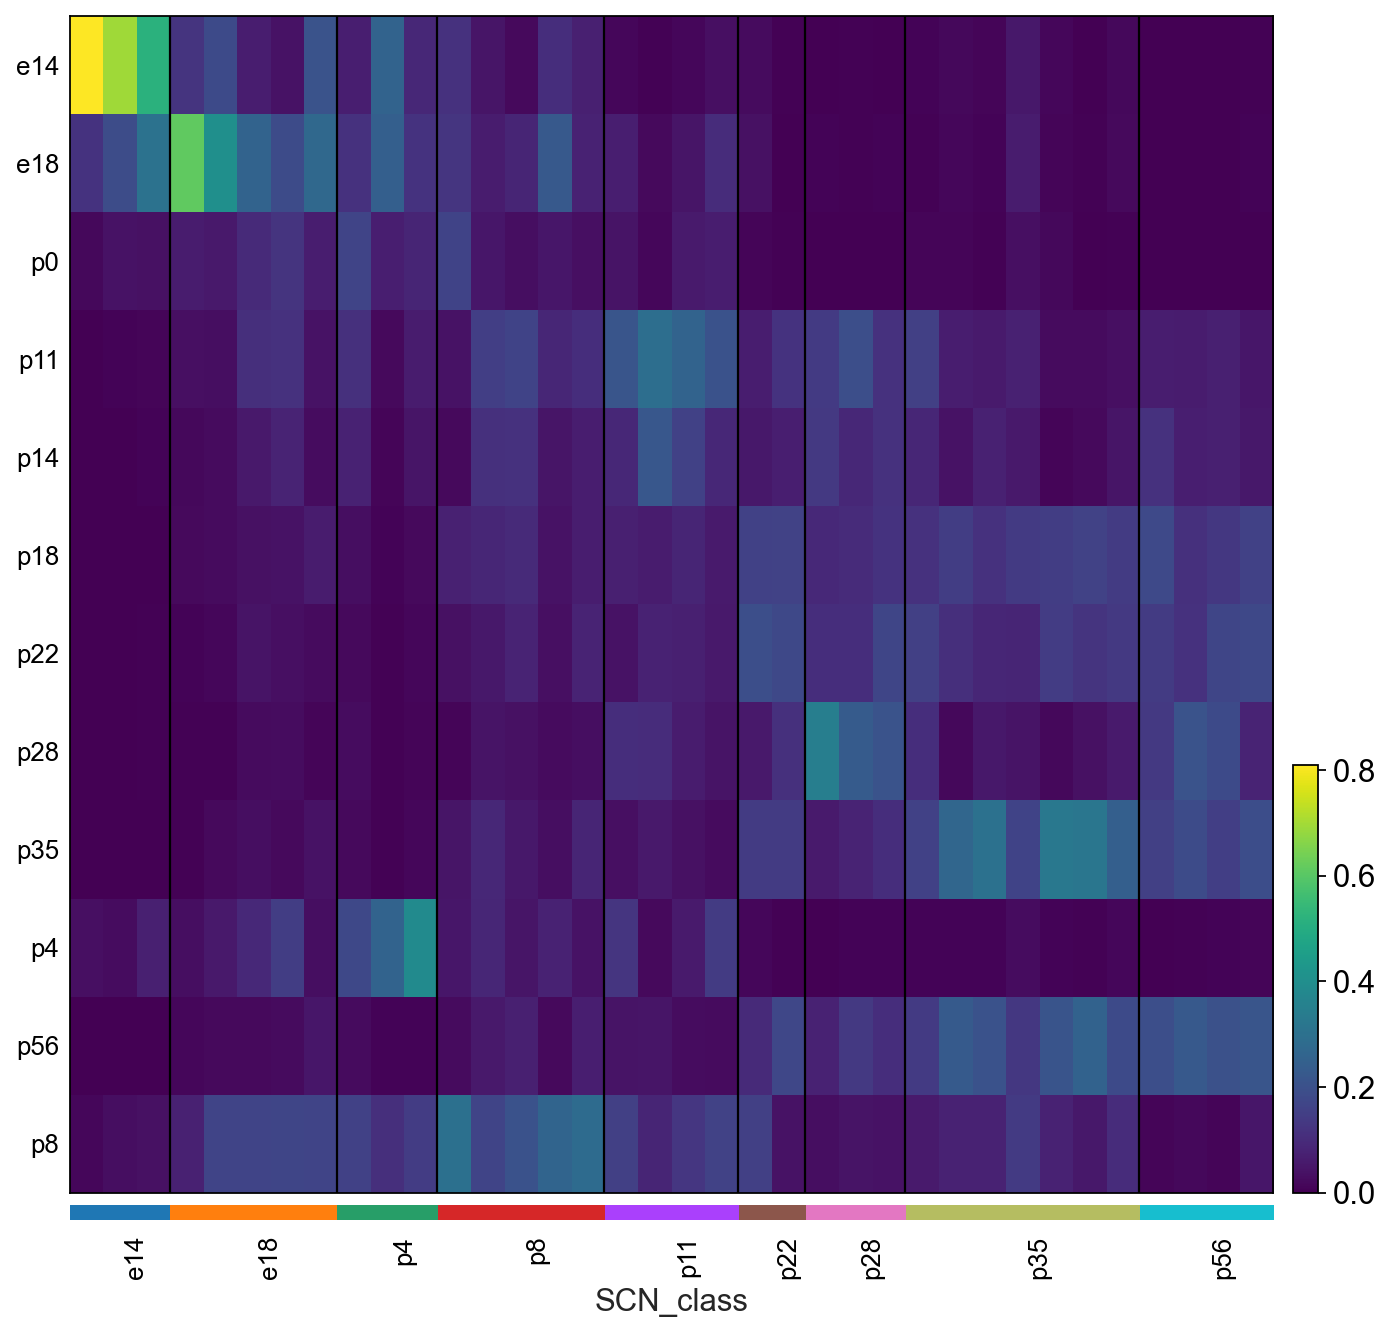

In [668]:
expTrain, expVal = pySCN.splitCommonAnnData(trainNorm_clf, ncells=200,dLevel='timepoint')

[cgenesA, xpairs, tspRF] = pySCN.scn_train(expTrain, nTopGenes = 100, nRand = 0,
                                           nTrees = 1000 ,nTopGenePairs = 100, dLevel = 'timepoint', 
                                           stratify=True, limitToHVG=True)
#classifier on held out test set
adVal = pySCN.scn_classify(expVal, cgenesA, xpairs, tspRF, nrand = 0)
ax = sc.pl.heatmap(adVal, adVal.var_names.values, groupby='SCN_class', cmap='viridis', dendrogram=False, swap_axes=True,figsize=(10,10))


In [696]:
adata_cmc_subset_classified = pySCN.scn_classify(adata_cmc_subset, cgenesA, xpairs, tspRF, nrand = 0)
predicted_eno1nfianfibcux1ko_subset_classified = pySCN.scn_classify(predicted_eno1nfianfibcux1ko_subset, cgenesA, xpairs, tspRF, nrand = 0)
predicted_eno1nfianfibcux1_over2_subset_classified = pySCN.scn_classify(predicted_eno1nfianfibcux1_over2_subset, cgenesA, xpairs, tspRF, nrand = 0)
predicted_eno1nfianfibcux1_over2_subset_classified = pySCN.scn_classify(predicted_eno1nfianfibcux1_over2_subset, cgenesA, xpairs, tspRF, nrand = 0)
predicted_eno1nfianfibcux1_over3_subset_classified = pySCN.scn_classify(predicted_eno1nfianfibcux1_over3_subset, cgenesA, xpairs, tspRF, nrand = 0)







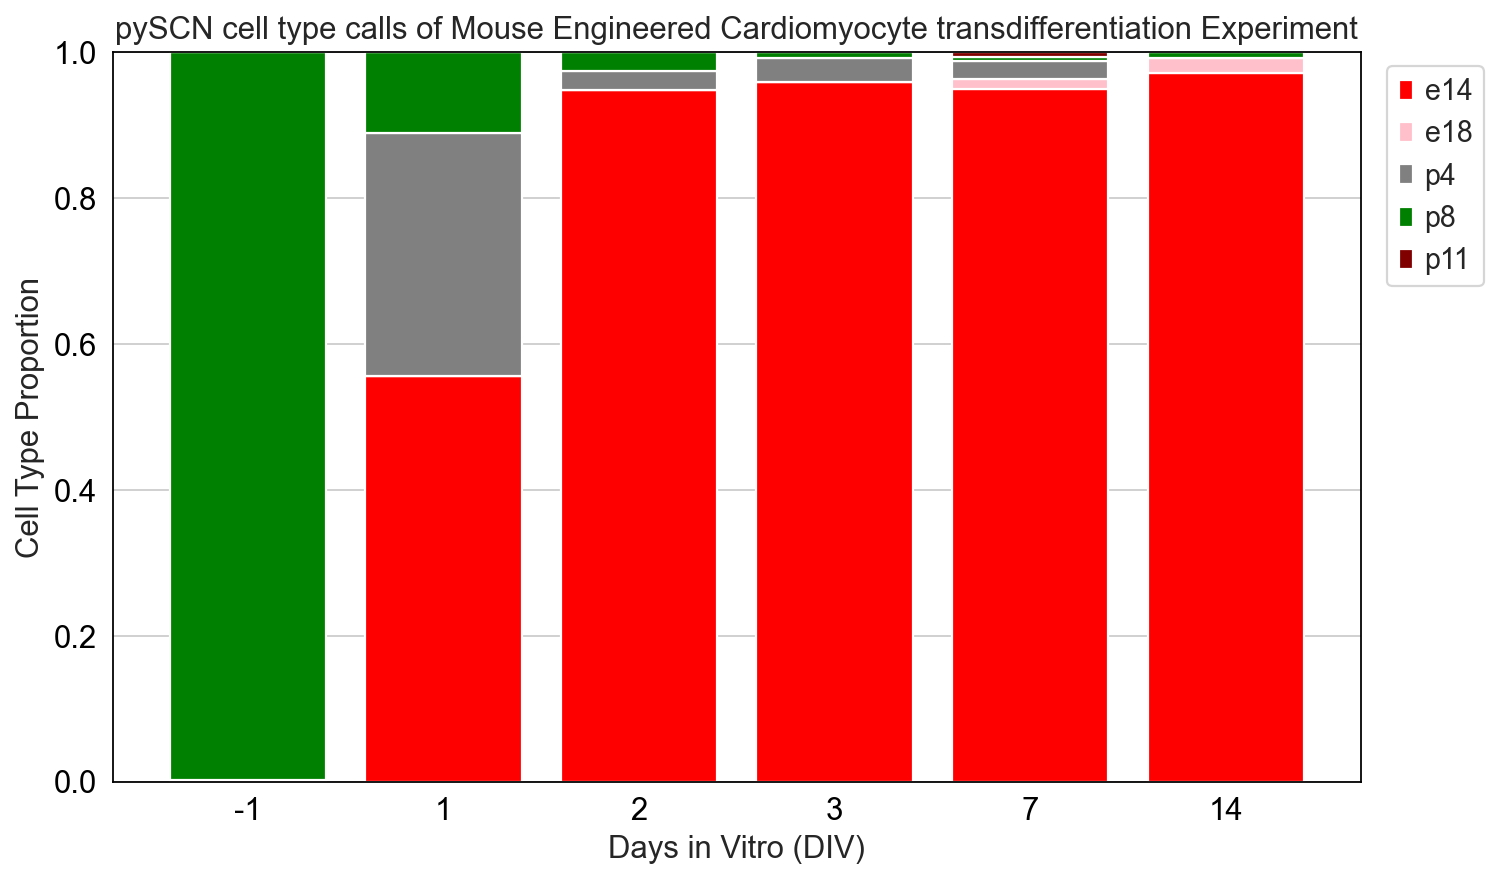

In [717]:
adata_cmc_subset.obs['SCN_class']=adata_cmc_subset_classified.obs['SCN_class']
#adata_cmc_subset.obs=adata_cmc_subset.obs.rename(columns={'SCN_class':'cardiac muscle scn maturity 2'})
for i in adata_cmc_subset.obs['Timepoint (days)'].unique():
    props[i]={}
    for j in adata_cmc_subset[adata_cmc_subset.obs['Timepoint (days)']==i].obs['SCN_class'].unique():
        props[i][j]=sum(adata_cmc_subset[adata_cmc_subset.obs['Timepoint (days)']==i].obs['SCN_class']==j)
        
scn_calls=pd.DataFrame(props).fillna(0)
scn_calls.update(scn_calls.div(scn_calls.sum(axis=0),axis=1))
scn_calls=scn_calls[['-1','1','2','3','7','14']]


#plt.figure(figsize=(35, 22), dpi=80)
plt.figure(figsize=(10, 6), dpi=80)



plt.bar(scn_calls.columns,scn_calls.loc['e14'],color='red')
plt.bar(scn_calls.columns, scn_calls.loc['e18'], bottom=scn_calls.loc['e14'], color='pink')
plt.bar(scn_calls.columns, scn_calls.loc['p4'], bottom=scn_calls.loc['e14']+scn_calls.loc['e18'], color='grey')
plt.bar(scn_calls.columns, scn_calls.loc['p8'], bottom=scn_calls.loc['e14']+scn_calls.loc['e18']+scn_calls.loc['p4'], color='green')
plt.bar(scn_calls.columns, scn_calls.loc['p11'], bottom=scn_calls.loc['e14']+scn_calls.loc['e18']+scn_calls.loc['p8']+scn_calls.loc['p4'], color='maroon')



plt.legend(["e14", "e18",'p4', "p8",'p11'],loc='upper right',bbox_to_anchor=(1.11, 1.0))
plt.xlabel('Days in Vitro (DIV)')
plt.ylabel('Cell Type Proportion')
plt.title('pySCN cell type calls of Mouse Engineered Cardiomyocyte transdifferentiation Experiment')
plt.savefig("pyscn_stackedbarplot.png") #save as png





Text(0.5, 1.0, 'pySCN cell type calls of Mouse Engineered Cardiomyocyte transdifferentiation Experiment')

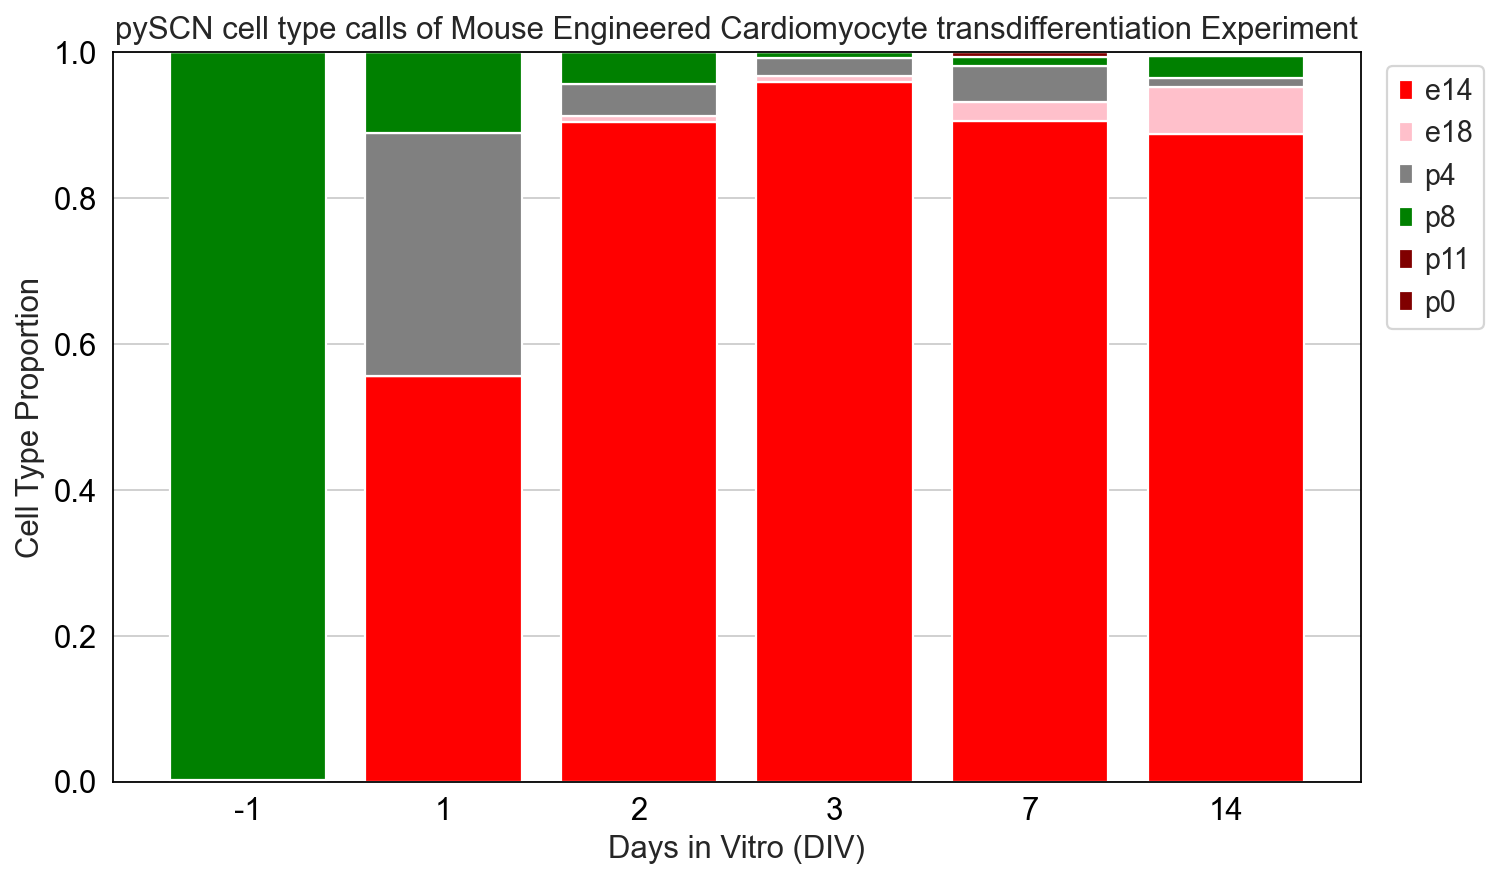

In [718]:
predicted_eno1nfianfibcux1ko_subset.obs['SCN_class']=predicted_eno1nfianfibcux1ko_subset_classified.obs['SCN_class']
#adata_cmc_subset.obs=adata_cmc_subset.obs.rename(columns={'SCN_class':'cardiac muscle scn maturity 2'})
for i in predicted_eno1nfianfibcux1ko_subset.obs['Timepoint (days)'].unique():
    props[i]={}
    for j in predicted_eno1nfianfibcux1ko_subset[predicted_eno1nfianfibcux1ko_subset.obs['Timepoint (days)']==i].obs['SCN_class'].unique():
        props[i][j]=sum(predicted_eno1nfianfibcux1ko_subset[predicted_eno1nfianfibcux1ko_subset.obs['Timepoint (days)']==i].obs['SCN_class']==j)
        
scn_calls=pd.DataFrame(props).fillna(0)
scn_calls.update(scn_calls.div(scn_calls.sum(axis=0),axis=1))
scn_calls=scn_calls[['-1','1','2','3','7','14']]


#plt.figure(figsize=(35, 22), dpi=80)
plt.figure(figsize=(10, 6), dpi=80)



plt.bar(scn_calls.columns,scn_calls.loc['e14'],color='red')
plt.bar(scn_calls.columns, scn_calls.loc['e18'], bottom=scn_calls.loc['e14'], color='pink')
plt.bar(scn_calls.columns, scn_calls.loc['p4'], bottom=scn_calls.loc['e14']+scn_calls.loc['e18'], color='grey')
plt.bar(scn_calls.columns, scn_calls.loc['p8'], bottom=scn_calls.loc['e14']+scn_calls.loc['e18']+scn_calls.loc['p4'], color='green')
plt.bar(scn_calls.columns, scn_calls.loc['p11'], bottom=scn_calls.loc['e14']+scn_calls.loc['e18']+scn_calls.loc['p8']+scn_calls.loc['p4'], color='maroon')
plt.bar(scn_calls.columns, scn_calls.loc['p0'], bottom=scn_calls.loc['e14']+scn_calls.loc['e18']+scn_calls.loc['p8']+scn_calls.loc['p4']+scn_calls.loc['p11'], color='maroon')




plt.legend(["e14", "e18",'p4', "p8",'p11','p0'],loc='upper right',bbox_to_anchor=(1.11, 1.0))
plt.xlabel('Days in Vitro (DIV)')
plt.ylabel('Cell Type Proportion')
plt.title('pySCN cell type calls of Mouse Engineered Cardiomyocyte transdifferentiation Experiment')






Text(0.5, 1.0, 'pySCN cell type calls of Mouse Engineered Cardiomyocyte transdifferentiation Experiment')

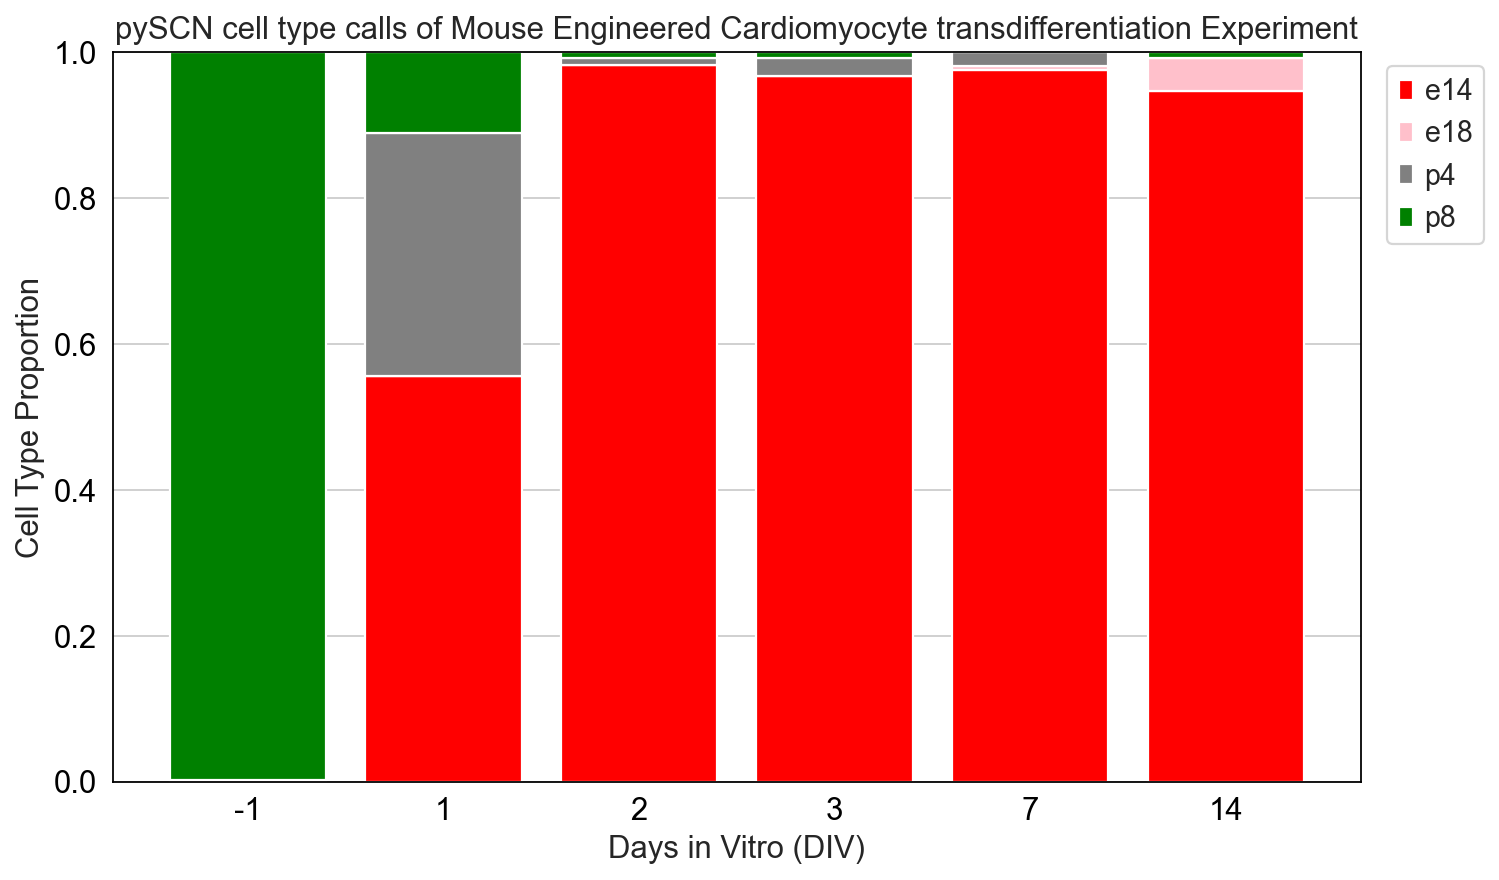

In [730]:
predicted_eno1nfianfibcux1_over3_subset.obs['SCN_class']=predicted_eno1nfianfibcux1_over3_subset_classified.obs['SCN_class']
#adata_cmc_subset.obs=adata_cmc_subset.obs.rename(columns={'SCN_class':'cardiac muscle scn maturity 2'})
for i in predicted_eno1nfianfibcux1_over3_subset.obs['Timepoint (days)'].unique():
    props[i]={}
    for j in predicted_eno1nfianfibcux1_over3_subset[predicted_eno1nfianfibcux1_over3_subset.obs['Timepoint (days)']==i].obs['SCN_class'].unique():
        props[i][j]=sum(predicted_eno1nfianfibcux1_over3_subset[predicted_eno1nfianfibcux1_over3_subset.obs['Timepoint (days)']==i].obs['SCN_class']==j)
        
scn_calls=pd.DataFrame(props).fillna(0)
scn_calls.update(scn_calls.div(scn_calls.sum(axis=0),axis=1))
scn_calls=scn_calls[['-1','1','2','3','7','14']]


#plt.figure(figsize=(35, 22), dpi=80)
plt.figure(figsize=(10, 6), dpi=80)



plt.bar(scn_calls.columns,scn_calls.loc['e14'],color='red')
plt.bar(scn_calls.columns, scn_calls.loc['e18'], bottom=scn_calls.loc['e14'], color='pink')
plt.bar(scn_calls.columns, scn_calls.loc['p4'], bottom=scn_calls.loc['e14']+scn_calls.loc['e18'], color='grey')
plt.bar(scn_calls.columns, scn_calls.loc['p8'], bottom=scn_calls.loc['e14']+scn_calls.loc['e18']+scn_calls.loc['p4'], color='green')


plt.legend(["e14", "e18",'p4', "p8"],loc='upper right',bbox_to_anchor=(1.11, 1.0))
plt.xlabel('Days in Vitro (DIV)')
plt.ylabel('Cell Type Proportion')
plt.title('pySCN cell type calls of Mouse Engineered Cardiomyocyte transdifferentiation Experiment')





